# Assignment 5: Network Security - Portscan

Network operators actively monitor their networks to protect against various intrusion attacks. Network attackers often perform random "portscans" of IP addresses to find vulnerable machines to compromise. Network Intrusion Detection Systems (NIDS) attempt to detect such behavior and flag these portscanners as malicious. 

In this assignment, you will analyze the NetFlow network measurement data from Assignment 4 to identify potentially malicious traffic sent to the Princeton campus network. You will then simulate an online algorithm for identifying malicious remote hosts.

This notebook has several parts. Each part contains sections marked TODO that you need to complete.

You may work with a partner on this assignment.

**Names:** Yang Song, Zhuo Qun Song

**NetIds:** yangsong, zsong

### Parsing IPFIX Data
The `netflow.csv` file contains pre-processed netflow data from a Princeton campus network border router. The data is "unsampled," i.e. it compiles flow statistics for every packet that traverses any interface on the border router.  We used the `nfdump` tool to process the raw NetFlow data that the router collected. Each row of the `netflow.csv` file, except for the header on top, logs the following information for a flow:

```
Date first seen, Time first seen (m:s), Date last seen, Time last seen (m:s), Duration (s), Protocol, 
Src IP addr, Src port, Dst IP addr, Dst port, Packets, Bytes, Flags, Input interface, Output interface		

```

To analyze this data, we first need to read it into a python data structure.  The following code uses the built-in `csv` library to read `netflow.csv` into a list of dictionaries.  The `csv` library documentation is here if you are interested: https://docs.python.org/2/library/csv.html

In [1]:
import csv

with open('netflow.csv', 'r') as netflow_file:
    netflow_reader = csv.DictReader(netflow_file)
    netflow_data = list(netflow_reader)
    
print "Number of flow records: {}".format(len(netflow_data))
print
print "Sample flow entry: {}".format(netflow_data[0])

Number of flow records: 105360

Sample flow entry: {'Dst IP addr': '128.112.213.189', 'Protocol': 'ICMP', 'Bytes': '94', 'Src port': '0', 'Src IP addr': '172.16.241.1', 'Input interface': '120', 'Packets': '1', 'Date first seen': '10/29/15', 'Output interface': '0', 'Duration (s)': '0', 'Time first seen (m:s)': '04:48.9', 'Flags': '.A....', 'Time last seen (m:s)': '04:48.9', 'Dst port': '11', 'Date last seen': '10/29/15'}


## ** Part A: TCP SYN Scan Detection**

In this part of the assignment, you will analyze TCP flow records to look for a TCP SYN scan attack. A [TCP SYN scan](https://en.wikipedia.org/wiki/Port_scanner#SYN_scanning) involves sending a TCP SYN packet to many different destinations to discover vulnerable machines on the network with open ports

### Background

In the previous assignment, we analyzed popular destinations by number of flows and by overall traffic volume. Such higher level statistics provide a coarse view of the network anomalies, but these statistics reveal less useful information about attacks and intrusion attempts. 

Abnormal activities are often difficult to detect amongst the amount of legitimate traffic that is typically found in a large enterprise network. Malicious hosts might not show up in lists of the top senders (either by bytes or by flows), and it can be difficult to determine the exact nature of attack traffic in advance. 

However, certain types of attacks have characteristic features that simplify their detection. For example, many attackers attempt to detect hosts running vulnerable services by scanning the address space using TCP SYN packets.  If a NetFlow record indicates that a flow contained a TCP SYN packet _but no packets with the ACK flag set_, we can conclude that this flow never completed and thus may be part of a TCP SYN scan---particularly if there are a lot of these flows.

When an attacker sends a TCP SYN packet as part of a TCP SYN scan, there are three possible outcomes:
- There is an active host at the destination IP address that is listening on the destination port of the SYN packet. In this case, the NetFlow record will contain both the TCP SYN and ACK flags in the flow record. These flows are difficult to distinguish from legitimate flows, because in this case a host actually answered the initial SYN. 
- There is no active host on the network at the destination IP address. In this case, we will only see TCP SYN flag. This is very different from the legitimate traffic behavior. It should be possible to identify malicious scanners by identifying these flows.
- The destination is alive, but the port to which the SYN is sent is closed. If a client connects to a server's non-listening port, the server will send back a RST/ACK packet. According to normal TCP implementation guidelines, the scanner will immediately stop any TCP connection attempts once it receives a RST. Like in the previous case, the NetFlow record will show SYN requests from the scanner host to the destination host but no SYN/ACK packets in response.

### Analysis

Let's first explore our NetFlow trace to determine whether the Princeton University campus network observes significant traffic with TCP SYN flags only (i.e., flows with TCP SYNs but no ACKs). 

In the following cell, determine the percentage of TCP flows in `netflow_data` that have SYN packet but no ACK packet. A flow has a SYN packet if there is an "S" in the "Flags" field.  A flow has an ACK packet if there is an "A" in the flags field.  Be sure to only consider TCP traffic (use the "Protocol" field).  

Print the percentage you found at the end of the cell with an informative label (e.g. `print "Percent SYN-only flows: {}".format(percent_synonly)`)

In [2]:
# TODO: determine the percentage of TCP flows in netflow_data that had a SYN packet but no ACK packet
percent_synonly = 100 * sum(map(lambda x: 'S' in x['Flags'] and 'A' not in x['Flags'], filter(lambda x: x['Protocol'] == 'TCP', netflow_data)))/float(len(filter(lambda x: x['Protocol'] == 'TCP', netflow_data)))
print "Percent SYN-only flows: {}".format(percent_synonly)

Percent SYN-only flows: 88.4330693662


Check your answer by passing it (as a float between 0 and 100) to the `check_synonly_percentage()` function below.  This compares the md5 hash of your answer (rounded to the nearest int) against the md5 hash of the correct answer.

In [3]:
from testing import check_synonly_percent

# TODO: pass the percentage of SYN-only TCP flows to the following function
check_synonly_percent(percent_synonly)

Hashes match. Your percentage of SYN-only flows is correct.


Each of the flows that fall into this category are TCP SYN scan candidates.

## **Part B: Port Scan Detection Using Known Bad Ports**

Another method of identifying attacks involves using TCP ports that are known to correspond to particularly vulnerable services.  For this assignment, we will consider ports 135, 139, 445, and 1433 as known bad ports. These correspond to Windows RPC, NetBIOS, SMB, and SQL-Snake attacks. We expect that most of the traffic to "known bad" ports are scanners, but that is not necessarily true for all traffic to these ports.  

In the following cell, test this hypothesis by identifying which flows in the NetFlow data are to known bad ports on the Princeton network (regardless of IP address). Then see whether these flows are more likely to be TCP SYN scans then flows to other ports:

1. Divide all the TCP flows in `netflow_data` into the following categories:
   1. SYN-only flows to known bad ports
   2. Other flows to known bad ports
   3. SYN-only flows to other ports'
   4. Other flows to other ports

2. From these sets, calculate the following three percentages, store them in variables, and print them with informative labels:
   1. Precent of flows to known bad ports out of all TCP flows
   2. Percent of SYN-only flows out of all TCP flows to known bad ports
   3. Percent of SYN-only flows out of all TCP flows to other ports

In [8]:
# TODO write code as described above
bad_ports = ["135", "139", "445", "1433"]

A = [flow for flow in netflow_data if flow['Protocol'] == 'TCP' and 'S' in flow['Flags'] and 'A' not in flow['Flags'] and flow['Dst port'] in bad_ports]
B = [flow for flow in netflow_data if flow['Protocol'] == 'TCP' and not ('S' in flow['Flags'] and 'A' not in flow['Flags']) and flow['Dst port'] in bad_ports]
C = [flow for flow in netflow_data if flow['Protocol'] == 'TCP' and 'S' in flow['Flags'] and 'A' not in flow['Flags'] and flow['Dst port'] not in bad_ports]
D = [flow for flow in netflow_data if flow['Protocol'] == 'TCP' and not ('S' in flow['Flags'] and 'A' not in flow['Flags']) and not flow['Dst port'] in bad_ports]

percent_tcp_bad = 100.0*len(A)/(len(A)+len(B)+len(C)+len(D))
percent_syn_tcp_bad = 100.0*len(A)/(len(A)+len(B))
percent_syn_tcp_other = 100.0*len(C)/(len(C)+len(D))

print "Precent of flows to known bad ports out of all TCP flows: {}".format(percent_tcp_bad)
print "Percent of SYN-only flows out of all TCP flows to known bad ports: {}".format(percent_syn_tcp_bad)
print "Percent of SYN-only flows out of all TCP flows to other ports: {}".format(percent_syn_tcp_other)

Precent of flows to known bad ports out of all TCP flows: 5.88347348083
Percent of SYN-only flows out of all TCP flows to known bad ports: 99.7922917147
Percent of SYN-only flows out of all TCP flows to other ports: 87.7214036813


Check the 3 percentages you found in the previous cell by passing them to the corresponding `check` functions below

In [5]:
from testing import check_percent_knownbad, check_percent_synonly_knownbad, check_percent_synonly_other

# TODO: pass percent values to following check functions
check_percent_knownbad(percent_tcp_bad)
check_percent_synonly_knownbad(percent_syn_tcp_bad)
check_percent_synonly_other(percent_syn_tcp_other)

Hashes match. Your percentage of known bad flows is correct.
Hashes match. Your percentage of SYN-only flows out of the known bad flows is correct.
Hashes match. Your percentage of SYN-only flows out of the remaining flows is correct.


In addition to identifying potentially malicious flows, a network operator would like to identify potentially malicious hosts. The operator can then block future traffic from these hosts. 
_______________________________

#### Question 1:
Why is it necessary to identify malicious hosts in order to stop port scans in real traffic? Why isn't identifying SYN-only flows sufficient? 

#### Answer 1:
In order to stop the port scans, we would need to block the hosts. Identifying SYN-only flows is insufficient because some SYN-only flows are legitimate and we would want to avoid blocking legitimate hosts.

_________________________
However, network operators want to avoid blocking benign traffic.  The potential for blocking benign traffic depends on the overlap between hosts that send malicious-looking traffic and hosts that send normal traffc. 

Complete the following code to find this overlap:
1. Find a set of all hosts (IP addresses) that sent SYN-only or known bad port flows to Princeton during the recorded netflow data. We will call these the "malicious hosts"
2. Find a set of all hosts that sent non-SYN-only flows to other (not known bad) ports. We will call these the "benign hosts"
2. Find the intersection of the malicious hosts with the benign hosts. We will call this intersection the "questionable" hosts.
3. Remove these "questionable" hosts from the "malicious hosts" and "benign hosts" sets.
3. Calculate and print 3 values with informative labels:
    1. The number of remaining malicious hosts 
    2. The number of remaining benign hosts
    3. The number of questionable hosts

Only include flows with source IPs external to the Princeton network (not 128.112.\*.\*).   We have provided an `internalIP()` function that returns True if the argument IP address is from within the Princeton network. 

The python `set` type will be useful, documentation here: https://docs.python.org/2/library/stdtypes.html#set-types-set-frozenset

In [62]:
# InternalIP returns true if the argument IP address is within the Princeton network
def internalIP(ip):
    s = ip.split('.')
    if s[0] == "128" and s[1] == "112":
        return True
    return False

# TODO: write code as described above
malicious_hosts = set(flow['Src IP addr'] for flow in netflow_data if flow['Protocol'] == 'TCP' and not internalIP(flow['Src IP addr']) and (('S' in flow['Flags'] and 'A' not in flow['Flags']) or flow['Dst port'] in bad_ports))
benign_hosts = set(flow['Src IP addr'] for flow in netflow_data if flow['Protocol'] == 'TCP' and not internalIP(flow['Src IP addr']) and (not ('S' in flow['Flags'] and 'A' not in flow['Flags']) and not flow['Dst port'] in bad_ports))
questionable_hosts = malicious_hosts & benign_hosts
malicious_hosts -= questionable_hosts
benign_hosts -= questionable_hosts

print "Number of malicious hosts: {}".format(len(malicious_hosts))
print "Number of benign hosts: {}".format(len(benign_hosts))
print "Number of questionable hosts: {}".format(len(questionable_hosts))

Number of malicious hosts: 4479
Number of benign hosts: 66
Number of questionable hosts: 12


Pass the counts you found into the following `check` functions to verify them

In [60]:
from testing import check_num_malicious_hosts, check_num_benign_hosts, check_num_questionable_hosts
# TODO: pass percent values to following check functions
check_num_benign_hosts(len(benign_hosts))
check_num_malicious_hosts(len(malicious_hosts))
check_num_questionable_hosts(len(questionable_hosts))

Hashes match. Your number of benign hosts is correct.
Hashes match. Your number of malicious hosts is correct.
Hashes match. Your number of questionable hosts is correct.


________________________
#### Question 2:
Who are all of these potentially malicious hosts? Choose 2 IP addresses in the set of "malicious hosts" and see what you can find out about them using `whois` and searching online.  Report the most interesting parts of your findings below. 

#### Answer 2:

whois 49.142.226.98
This address is for Hyundai Communications Network, which is a digital cable TV and internet provider in South Korea.

whois 184.105.139.76
This address is for Hurricane Electric, which is an internet service provider in the United States.

It seemed that these malicious hosts (and most of the other ones we tried) were from large internet service providers. This is expected because most of the web traffic is from large internet service providers.

__________________________________
## **Part C: Online Port Scan Detection**

In the previous sections, we used offline analysis of pre-recorded traffic to identify potentially malicious hosts. A real network operator would not want to wait for offline analysis in order to detect potential threats.  Instead, he or she would configure a network intrusion detection system (NIDS) to use an online port scan detection algorithm to classify hosts as benign or malicious, updating these classifications in real-time as traffic flows occur. 

### Bro's Port Scan Detection Algorithm

The port scan detection algorithm used in the [Bro system](https://pdfs.semanticscholar.org/f121/cde8d3d5364717caf2b91d27a270ec004cac.pdf) was published in 1999 by Vern Paxson, et al.

Bro's detection algorithm builds on the same intution that failed connection attempts (SYN-only or SYN/RST flows) are good indicators for identifying scans.

The algorithm treats connection attempts differently depending on the service (determined by port) to which the connection is intended.  Bro only tracks failed connection attempts (SYN-only or SYN/RST) to a specific set of "known good" services.

For all other services, Bro tracks all connection attempts, whether or not the attempts fail or succeed. 

For each sending host, Bro counts the number of distinct destination addresses corresponding to tracked connection attempts. If the number exceeds some threshold, `T`, Bro flags the host as a scanner.

By default, the set of services for which only failures are considered includes HTTP (80), SSH (22), Telnet (23), SMTP (25), IDENT (113), FTP (20), and Gopher (70). These services are "known good," i.e. we expect many connections to be initiated to these services, so we should not count successful connection attempts against a sending host. 

#### Task: Implement Bro's port scan detection algorithm.

Complete the Bro class below to implement Bro's port scan detection algorithm.  

In [41]:
from collections import defaultdict

# TODO: complete the methods marked TODO in the Bro class to implement the Bro algorithm
class Bro:
    
    # class constructor saves the parameter threshold value and sets instance variables
    def __init__(self, threshold):
        self.T = threshold
        
        # self.good_services is the list of port numbers to which successful connections 
        #     (SYN and ACK) should not be tracked
        self.good_services = [80, 22, 23, 25, 113, 20, 70]
        
        # self.tracked maps sending hosts to a set of destination addresses
        #     from tracked connection attempts 
        self.tracked = defaultdict(set)

        
    # TODO: block_connection() takes a sending host IP address of an incoming connection
    #       returns True if the connection should be blocked (because the host has surpassed
    #       the threshold of destination addresses in tracked connection attempts) or False otherwise
    def block_connection(self, host_ip):
        return len(self.tracked[host_ip]) > self.T
    
    
    # TODO: process_flow() takes a netflow record of a TCP flow that was not blocked
    #       (as a netflow record dict) and should update self.tracked
    #       with the contents of the record
    def process_flow(self, netflow_record):
        if not int(netflow_record['Dst port']) in self.good_services: # Unnecessary
            self.tracked[netflow_record['Src IP addr']].add(netflow_record['Dst IP addr'])
        elif 'S' in netflow_record['Flags'] and 'A' not in netflow_record['Flags']:
            self.tracked[netflow_record['Src IP addr']].add(netflow_record['Dst IP addr'])            

Note that a full implementation of Bro's detection algorithm would also contain a moving time window over which tracked connection attempts are remembered.  This prevents a benign host from being blocked if it is dynamically assigned an IP address that previously belonged to an attacker. However, the NetFlow data we are using in this assignment is from only approximately 5 minutes of traffic, so we don't need to worry about time windows. 

The following `run_bro()` function takes a threshold value and runs your Bro algorithm on the NetFlow data, returning a set of all addresses blocked during the course of the algorithm. This function is already complete.

In [42]:
def run_bro(threshold):
    blocked_hosts = set()
    bro = Bro(threshold)
    for flow in netflow_data:
        src_ip = flow["Src IP addr"]
        if flow["Protocol"] != "TCP":
            continue
        if internalIP(src_ip):
            continue
        block = bro.block_connection(src_ip)
        if block:
            blocked_hosts.add(src_ip)
            continue
        bro.process_flow(flow)
    return blocked_hosts      

Before running Bro on their network intrusion detection system, a network operator might want to know how sensitive the algorithm is to the threshold variable `T`. 

In the following cell, create a 120 element list such that element `i` contains the number of blocked hosts in the set returned by `run_bro(i)`.  Then pass the list to the `plot_bro()` function to plot a sensitivity curve.

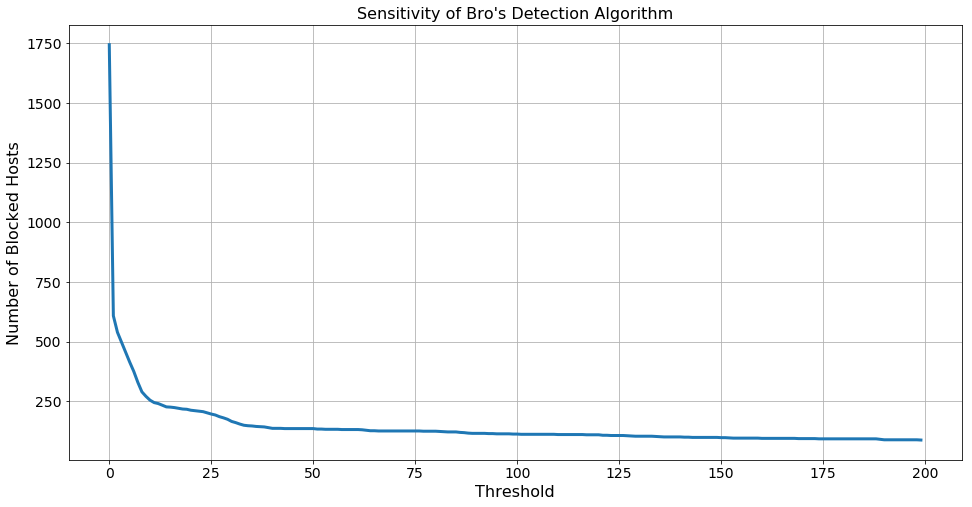

In [45]:
%matplotlib inline
from plotting import plot_bro

# TODO: generate the list described above
bro = map(len, [run_bro(i) for i in range(200)])
    
# TODO: pass the list to the plot_bro function
plot_bro(bro)

_____
#### Question 3:
A threshold of 100 is the default for Bro's algorithm. Given the results in the above plot, why do you think this value was chosen?  What are the pros and cons of choosing a higher or lower threshold?

#### Answer 3:

Choosing a number in the range [50,120] is probably good, because there were 1745 hosts that sent multiple messages, but very many of the 112 hosts that sent 100 messages also sent more (87 of the 112 sent 200 or more, determined by running the above code on 200 hosts). If a lower threshold is chosen, then there is a risk of blocking benign traffic, whereas a higher threshold allows malicious hosts to send more traffic before being blocked, which could increase their ability to detect vulnerabilities in the network.

#### Question 4:
A threshold of 100 would have blocked $\approx$115 hosts (if your implementation didn't, you should check it for bugs).  This is many fewer hosts than the number of malicious hosts found in Part B.  What differences between Bro's algorithm and the method usd in Part B caused this difference? Which method do you think is more likely to be accurate? Why?

#### Answer 4:

From looking at bro[0] (which was 1745), we saw that over two-thirds of the hosts in malicious_hosts (which is a subset of run_bro(-1)) sent bad traffic only once, and around 96% of them sent bad traffic to fewer than 25 IP addresses within the network. The difference is that the method in Part B detects a host as malicious if it sends only one bad flow, whereas there is thresholding in Bro's algorithm.

We think that the two methods say different things. Bro's algorithm probably finds genuine port scanners that are looking to detect open ports on the network, whereas the method in Part B will do a better job of detecting attackers that are sending messages to various different networks with the goal of finding a vulnerable network.

There are many other online port scan detection algorithms in addition to Bro. For example, the Threshold Random Walk (TRW) algorithm uses maximum likelihood ratios to tune the threshold parameter in an attempt to block as much malicious traffic as possible without blacklisting benign hosts. 

If you are curious, the TRW algorithm is described in this paper: http://www.icir.org/vern/papers/portscan-oak04.pdf. 

## Submission


**Remember to "Save and Checkpoint" (from the "File" menu above) before you leave the notebook or close your tab.**

Submit this file (Assignment5_Notebook.ipynb) on CS Dropbox here: <>. Submit only once for both partners. Remember to put your names and netids in the marked location at the top of this file. 